# Regression Diagnostics: A Beginner-Friendly Guide

This notebook introduces regression diagnostics and model transformations. You'll learn why diagnostics matter, how to check linear regression assumptions and how to apply and interpret common transformations.

## 1. Why Do Regression Diagnostics?

Regression diagnostics help you understand why a model might underperform and how to fix it. Diagnostics let you:
- Check if your model's assumptions are met
- Identify problems (like non-linearity or outliers)
- Apply the right transformation to improve your model

## 2. The LINE Assumptions of Linear Regression

A good linear regression model should satisfy these assumptions (remember: **LINE**):
- **L: Linearity** – The relationship between predictors and target is linear
- **I: Independence** – Observations are independent
- **N: Normality** – Residuals (errors) are normally distributed
- **E: Equal Variance (Homoscedasticity)** – Residuals have constant variance

We'll see how to check and address these in practice.

## 3. Linear Transformations

Linear transformations change the scale or location of your variables without changing the model's performance. They make results easier to interpret or compare. 

**Why use them?** The main reason is to make modeling results **more useful or interpretable to stakeholders**. For example, converting imperial units to metric for international audiences.

### Types of Linear Transformations:
- **Scaling**: Multiply/divide by a constant (e.g., pounds to kilograms)
- **Shifting**: Add/subtract a constant (e.g., center data around zero)  
- **Standardization**: Center and scale so variables have mean 0 and std 1

**Key insight:** These transformations don't change the model's fit (same R-squared), but do change how you interpret coefficients.

In [9]:
# Example: Scaling a Predictor (Imperial to Metric)
import pandas as pd
import statsmodels.api as sm

# Load data and create models with different units
data = pd.read_csv("auto-mpg.csv")

# Original model (imperial units)
y = data["mpg"]
X_imperial = data[["weight", "model year"]]
model_imperial = sm.OLS(y, sm.add_constant(X_imperial))
results_imperial = model_imperial.fit()

# Scaled model (metric units)
X_metric = X_imperial.copy()
X_metric["weight"] = X_metric["weight"] * 0.453592  # Convert lbs to kg
model_metric = sm.OLS(y, sm.add_constant(X_metric))
results_metric = model_metric.fit()

print("Imperial model weight coefficient:", results_imperial.params["weight"])
print("Metric model weight coefficient:", results_metric.params["weight"])
print("Imperial model R-squared:", round(results_imperial.rsquared, 4))
print("Metric model R-squared:", round(results_metric.rsquared, 4))
print("Same R-squared?", round(results_imperial.rsquared, 4) == round(results_metric.rsquared, 4))

Imperial model weight coefficient: -0.006632075291836657
Metric model weight coefficient: -0.014621235144880519
Imperial model R-squared: 0.8082
Metric model R-squared: 0.8082
Same R-squared? True


**Interpretation:**
- Imperial: "Each additional pound decreases mpg by ~0.006"
- Metric: "Each additional kilogram decreases mpg by ~0.014" 
- Same information, different units! The larger coefficient makes sense because a kilogram is heavier than a pound.

## 4. Shifting and Centering

**Shifting** means adding or subtracting a constant. **Centering** (shifting to make mean = 0) is especially useful because it makes the intercept more meaningful.

**Before centering:** Intercept = "Expected mpg when weight = 0 and year = 0" (impossible!)
**After centering:** Intercept = "Expected mpg for average weight and year" (meaningful!)

In [10]:
# Center the predictors to make intercept meaningful
X = data[["weight", "model year"]].copy()
X_centered = X - X.mean()

model_centered = sm.OLS(y, sm.add_constant(X_centered))
results_centered = model_centered.fit()

print("Original intercept:", results_imperial.params["const"])
print("Centered intercept:", results_centered.params["const"])
print(f"Average car weight: {data['weight'].mean():.0f} lbs")
print(f"Average model year: {data['model year'].mean():.0f}")

Original intercept: -14.347253017615689
Centered intercept: 23.44591836734694
Average car weight: 2978 lbs
Average model year: 76


**Interpretation:**
- Now, the intercept represents the expected mpg for a car with average weight and model year.

## 5. Standardization

Standardization combines centering and scaling: `(x - mean) / std`. This makes all variables have mean = 0 and std = 1.

**Why standardize?** To **compare the relative importance** of predictors. When variables have different units (pounds, years, cylinders), you can't directly compare their coefficients. After standardization, larger coefficients indicate more important variables.

In [11]:
# Standardize predictors to compare importance
X_std = (X - X.mean()) / X.std()
model_std = sm.OLS(y, sm.add_constant(X_std))
results_std = model_std.fit()

print("Standardized coefficients:")
for var in ["weight", "model year"]:
    coef = results_std.params[var]
    print(f"{var}: {coef:.3f}")
    
print(f"\nWeight has the largest coefficient magnitude, so it's most important!")
print(f"Each 1 std increase in weight decreases mpg by {abs(results_std.params['weight']):.2f}")
print(f"Each 1 std increase in model year increases mpg by {results_std.params['model year']:.2f}")

Standardized coefficients:
weight: -5.633
model year: 2.790

Weight has the largest coefficient magnitude, so it's most important!
Each 1 std increase in weight decreases mpg by 5.63
Each 1 std increase in model year increases mpg by 2.79


**Interpretation:**
- Standardized coefficients are in "standard deviation units"
- You can now directly compare which predictor has more impact
- The predictor with the largest absolute coefficient is most important

## 6. Nonlinear Transformations

Sometimes relationships aren't straight lines! Nonlinear transformations help capture curves, interactions, and complex patterns.

### Common Nonlinear Transformations:
- **Log transformations**: Good for skewed data or when effects are multiplicative
- **Polynomial regression**: Adds x², x³ terms to capture curves  
- **Interaction terms**: Let one variable's effect depend on another variable

**Key difference:** These CAN improve model fit (better R-squared) by capturing nonlinear patterns.

Linear model R-squared: 0.6926
Log model R-squared: 0.7127


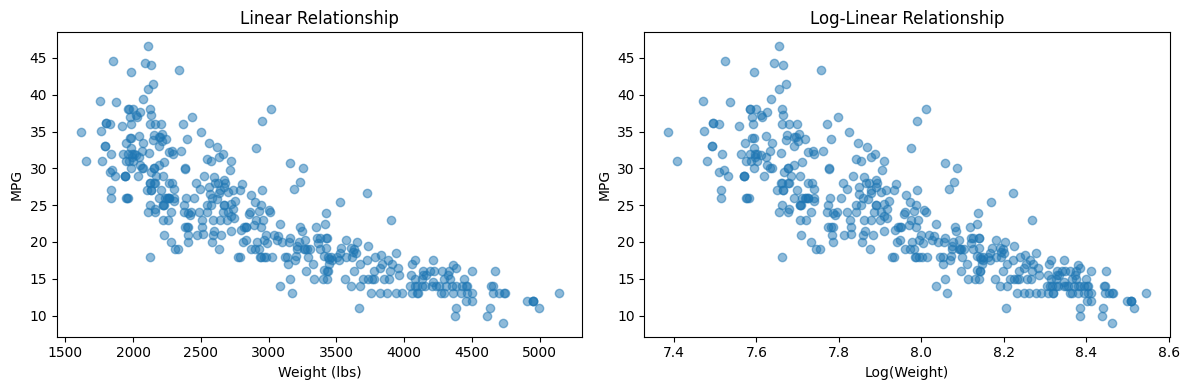

In [12]:
# Example: Log transformation for nonlinear relationships
import numpy as np
import matplotlib.pyplot as plt

# Compare linear vs log transformation
X_original = data[["weight"]].copy()
X_log = data[["weight"]].copy()
X_log["weight"] = np.log(X_log["weight"])

# Fit both models
model_original = sm.OLS(y, sm.add_constant(X_original))
results_original = model_original.fit()

model_log = sm.OLS(y, sm.add_constant(X_log))
results_log = model_log.fit()

print(f"Linear model R-squared: {results_original.rsquared:.4f}")
print(f"Log model R-squared: {results_log.rsquared:.4f}")

# Visualize the difference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(data["weight"], y, alpha=0.5)
ax1.set_title("Linear Relationship")
ax1.set_xlabel("Weight (lbs)")
ax1.set_ylabel("MPG")

ax2.scatter(np.log(data["weight"]), y, alpha=0.5)
ax2.set_title("Log-Linear Relationship")
ax2.set_xlabel("Log(Weight)")
ax2.set_ylabel("MPG")
plt.tight_layout()
plt.show()

**Interpretation:**
- Log transformation can improve model fit when relationships are curved
- Log coefficient interpretation: "1% increase in weight → X% decrease in mpg"

In [13]:
# Example: Polynomial regression to capture curves
X_poly = data[["weight", "model year"]].copy()
X_poly["weight_squared"] = X_poly["weight"] ** 2

model_linear = sm.OLS(y, sm.add_constant(data[["weight", "model year"]]))
results_linear = model_linear.fit()

model_poly = sm.OLS(y, sm.add_constant(X_poly))
results_poly = model_poly.fit()

print(f"Linear model R-squared: {results_linear.rsquared:.4f}")
print(f"Polynomial model R-squared: {results_poly.rsquared:.4f}")
print(f"Improvement: {results_poly.rsquared - results_linear.rsquared:.4f}")

# Check if the squared term is significant
print(f"\nWeight² coefficient p-value: {results_poly.pvalues['weight_squared']:.4f}")
if results_poly.pvalues['weight_squared'] < 0.05:
    print("The squared term is significant! The relationship is curved.")
else:
    print("The squared term is not significant. Linear relationship is fine.")

Linear model R-squared: 0.8082
Polynomial model R-squared: 0.8503
Improvement: 0.0421

Weight² coefficient p-value: 0.0000
The squared term is significant! The relationship is curved.


**Interpretation:**
- Squared terms let you model curved relationships (U-shapes, inverted U-shapes)
- Check the p-value to see if the curved relationship is statistically significant

In [14]:
# Example: Interaction terms - when effects depend on other variables
X_inter = data[["weight", "model year"]].copy()
X_inter["weight_x_year"] = X_inter["weight"] * X_inter["model year"]

model_no_interaction = sm.OLS(y, sm.add_constant(data[["weight", "model year"]]))
results_no_interaction = model_no_interaction.fit()

model_interaction = sm.OLS(y, sm.add_constant(X_inter))
results_interaction = model_interaction.fit()

print(f"No interaction R-squared: {results_no_interaction.rsquared:.4f}")
print(f"With interaction R-squared: {results_interaction.rsquared:.4f}")

print(f"\nInteraction coefficient: {results_interaction.params['weight_x_year']:.6f}")
print(f"Interaction p-value: {results_interaction.pvalues['weight_x_year']:.4f}")

if results_interaction.pvalues['weight_x_year'] < 0.05:
    print("Significant interaction! Weight's effect depends on model year.")
else:
    print("No significant interaction. Weight's effect is consistent across years.")

No interaction R-squared: 0.8082
With interaction R-squared: 0.8339

Interaction coefficient: -0.000458
Interaction p-value: 0.0000
Significant interaction! Weight's effect depends on model year.


**Interpretation:**
- Interaction terms capture when one variable's effect depends on another
- If significant, it means the relationship between variables changes based on context
- Example: "Weight matters more for older cars than newer cars"

## 7. Checking Regression Assumptions (LINE)

Always check if your model meets the LINE assumptions. If not, transformations can help!

### Quick Diagnostic Checklist:
- **Linearity**: Residuals vs fitted should show random scatter (no curves)
- **Independence**: Consider your data collection method  
- **Normality**: Residuals should be roughly bell-shaped
- **Equal Variance**: Residual spread should be constant (no funnel shapes)

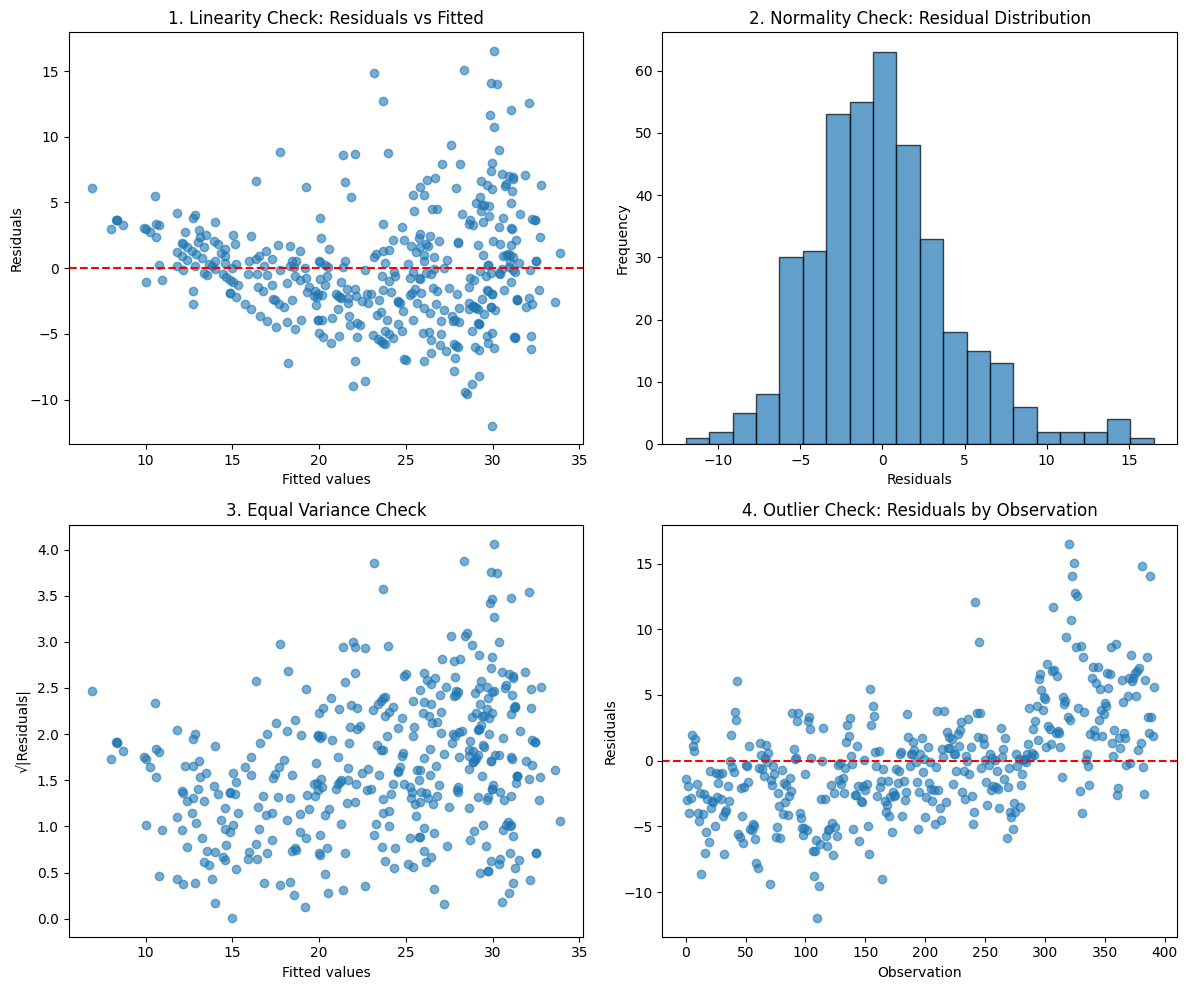

Model R-squared: 0.6926
Residual standard deviation: 4.32

Look for:
• Random scatter in plot 1 (good linearity)
• Bell curve in plot 2 (good normality)
• Constant spread in plot 3 (good equal variance)
• No extreme outliers in plot 4


In [15]:
# Check regression assumptions with diagnostic plots
import matplotlib.pyplot as plt

# Use our simple linear model for diagnostics
simple_model = sm.OLS(y, sm.add_constant(data[["weight"]]))
simple_results = simple_model.fit()

residuals = simple_results.resid
fitted = simple_results.fittedvalues

# Create diagnostic plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Linearity: Residuals vs Fitted
ax1.scatter(fitted, residuals, alpha=0.6)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')
ax1.set_title('1. Linearity Check: Residuals vs Fitted')

# 2. Normality: Histogram of residuals
ax2.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('2. Normality Check: Residual Distribution')

# 3. Equal Variance: Scale-Location plot
ax3.scatter(fitted, np.sqrt(np.abs(residuals)), alpha=0.6)
ax3.set_xlabel('Fitted values')
ax3.set_ylabel('√|Residuals|')
ax3.set_title('3. Equal Variance Check')

# 4. Outliers: Residuals vs Leverage (simplified)
ax4.scatter(range(len(residuals)), residuals, alpha=0.6)
ax4.axhline(0, color='red', linestyle='--')
ax4.set_xlabel('Observation')
ax4.set_ylabel('Residuals')
ax4.set_title('4. Outlier Check: Residuals by Observation')

plt.tight_layout()
plt.show()

print(f"Model R-squared: {simple_results.rsquared:.4f}")
print(f"Residual standard deviation: {np.std(residuals):.2f}")
print("\nLook for:")
print("• Random scatter in plot 1 (good linearity)")
print("• Bell curve in plot 2 (good normality)")  
print("• Constant spread in plot 3 (good equal variance)")
print("• No extreme outliers in plot 4")

**What to Look For:**
- **Good:** Random scatter around 0 line
- **Bad:** Curved patterns (try polynomial/log transforms), funnel shapes (try log transforms)
- **Outliers:** Points far from the main cluster (investigate or consider removing)

## 8. Summary

**Key Takeaways:**
- **Linear transformations** (scaling, centering, standardizing) improve interpretability without changing model fit
- **Nonlinear transformations** (log, polynomial, interactions) can improve model fit by capturing complex patterns  
- **Always check LINE assumptions** using diagnostic plots
- **Start simple** - try log transformations first, they solve many problems
- **Think about stakeholders** - choose transformations that make business sense

### Transformation Quick Reference:
| Problem | Solution | When to Use |
|---------|----------|-------------|
| Different units | Scaling | International audiences |
| Uninterpretable intercept | Centering | Want meaningful baseline |
| Can't compare importance | Standardization | Multiple predictors |
| Curved relationship | Log/Polynomial | Nonlinear patterns |
| Context-dependent effects | Interactions | Effects vary by group |

**Next steps:** Practice with your own data, start with simple models, and gradually add complexity only when diagnostics suggest it's needed!

### When Do You Need Transformations?

**Problem signs & solutions:**
- **Curved residual pattern** → Try polynomial or log transformations
- **Funnel-shaped residuals** → Try log transformation of target variable
- **Non-normal residuals** → Log transformation often helps
- **Different relationships by group** → Try interaction terms

**Decision framework:**
1. Fit simple model
2. Check diagnostic plots
3. If assumptions violated → apply appropriate transformation
4. Re-check diagnostics
5. Compare model performance (R-squared, interpretability)

In [16]:
# Practical example: When transformations help
print("TRANSFORMATION DECISION GUIDE:")
print("="*50)

# Check our simple model assumptions
residuals = simple_results.resid
fitted = simple_results.fittedvalues

# Simple tests for assumption violations
print(f"1. Linearity check:")
# Look for patterns in residuals
correlation_resid_fitted = np.corrcoef(fitted, residuals)[0,1]
print(f"   Residual-fitted correlation: {correlation_resid_fitted:.4f}")
if abs(correlation_resid_fitted) > 0.1:
    print("   ⚠️ Possible linearity violation - try polynomial/log transform")
else:
    print("   ✅ Linearity looks good")

print(f"\n2. Normality check:")
# Simple normality test
from scipy import stats
_, p_value = stats.jarque_bera(residuals)
print(f"   Normality test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("   ⚠️ Residuals not normal - try log transform")
else:
    print("   ✅ Residuals approximately normal")

print(f"\n3. Equal variance check:")
# Split data and compare variance
mid_point = np.median(fitted)
low_var = np.var(residuals[fitted <= mid_point])
high_var = np.var(residuals[fitted > mid_point])
variance_ratio = high_var / low_var
print(f"   Variance ratio (high/low fitted): {variance_ratio:.2f}")
if variance_ratio > 2 or variance_ratio < 0.5:
    print("   ⚠️ Unequal variance - try log transform of target")
else:
    print("   ✅ Variance looks constant")

print(f"\n💡 TIP: Start with log transformations - they often solve multiple problems!")

TRANSFORMATION DECISION GUIDE:
1. Linearity check:
   Residual-fitted correlation: -0.0000
   ✅ Linearity looks good

2. Normality check:
   Normality test p-value: 0.0000
   ⚠️ Residuals not normal - try log transform

3. Equal variance check:
   Variance ratio (high/low fitted): 2.08
   ⚠️ Unequal variance - try log transform of target

💡 TIP: Start with log transformations - they often solve multiple problems!
